# **Cleaning & EDA - Part A**

April 2021

- Getting more data 
- Univariate analysis
- Basic bivariate analysis (numeric vs categorical combos only)

In [1]:
# My own module
import eda_assist as ea

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.svm import OneClassSVM
from sklearn.impute import KNNImputer
# from sklearn.covariance import EllipticEnvelope
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Display settings
pd.options.display.float_format = "{:.2f}".format
plt.style.use('seaborn-whitegrid') 

# Plots show up a bit blurry but at least is github friendly
%matplotlib inline 

# Not githib friendly but much nicer when running locally
# %config InlineBackend.figure_format = 'svg'

# So that it updates with any changes made in *.py files 
%load_ext autoreload
%autoreload 2

#### **Read in Data**

In [2]:
train = pd.read_csv('../datasets/training.csv', dtype={'Year': int})
test = pd.read_csv('../datasets/testing.csv', dtype={'Year': int})

ea.summarise(train)

Summary Below
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2094 entries, 0 to 2093
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            2094 non-null   object 
 1   Year               2094 non-null   int64  
 2   InfantMortality    2094 non-null   float64
 3   Health_exp         2065 non-null   float64
 4   Life_exp           2094 non-null   float64
 5   GDP_cap            2075 non-null   float64
 6   Employment         2052 non-null   float64
 7   Status             2094 non-null   object 
 8   MeanSchooling      2056 non-null   float64
 9   ElectricityAccess  2027 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 163.7+ KB
None


,Year,InfantMortality,Health_exp,Life_exp,GDP_cap,Employment,MeanSchooling,ElectricityAccess
count,2094.00,2094.00,2065.00,2094.00,2075.00,2052.00,2056.00,2027.00
mean,2009.01,27.75,6.12,70.25,12482.86,58.30,7.91,79.07
std,5.49,26.91,2.63,8.86,18187.26,11.21,3.24,30.59
min,2000.00,1.70,1.03,39.44,111.93,30.61,1.10,1.90
25%,2004.00,6.90,4.06,65.35,1244.36,50.98,5.20,65.45
50%,2009.00,16.45,5.74,72.38,4167.67,57.73,8.20,98.22
75%,2014.00,42.60,7.99,76.80,14778.25,65.57,10.60,100.00
max,2018.00,139.50,20.41,83.60,116654.26,87.82,14.10,100.00
Variance,30.15,724.15,6.92,78.51,330776474.56,125.63,10.49,935.93
IQR,10.00,35.70,3.93,11.45,13533.89,14.60,5.40,34.55


#### **Getting More Data**

- HDI is "a statistic composite index of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of human development." ~ Wikipedia
- Could be nice to use the HDI score of a particular country instead of [one-hot-encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) over 100 countries, which can lead to [the curse of dimensionality](https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e)
- Though adding variables like HDI might cause <u>multicollinearity</u> as the HDI is in itself a measure calculated using factors such as education and mortality rates etc., which are variables already in our dataset


In [3]:
hdi = pd.read_csv('../datasets/hdi.csv')
hdi.sample(10)

,Country,HDI,Year
2957,Azerbaijan,0.75,2016
2035,Canada,0.90,2011
514,Uzbekistan,0.61,2002
2780,Bolivia,0.70,2015
2707,Russia,0.81,2014
3435,Maldives,0.73,2018
1142,Honduras,0.60,2006
3278,Sweden,0.94,2017
429,Iran,0.67,2002
2258,Guatemala,0.62,2012


Which countries are in our **train** and **test** dataset but not in our **hdi** dataset

In [4]:
ea.identify_country_mismatches(train, test, hdi)
ea.search_substrings(hdi)

In train not in hdi
{'Cabo Verde', 'Brunei Darussalam', 'Syrian Arab Republic', 'Russian Federation'}

Geting everything in test not in hdi
{'Cabo Verde', 'Brunei Darussalam', 'Syrian Arab Republic', 'Russian Federation'}


"In the HDI dataset these values show as ['Brunei' 'Cape Verde' 'Russia' 'Syria']"

**There are a few string mismatches ⬆️**

- Corrections below



In [5]:
# Correct it to the strings displayed above in both our train and test set
train, test = ea.correct_mismatches(train, test)

In [6]:
# Match country and year with its hdi rank
train = pd.merge(train, hdi, on = ['Country', 'Year'], how='inner')

# Do the same with the test set
test = pd.merge(test, hdi, on = ['Country', 'Year'], how='inner')

#### <span style="color:black"><u>**Univariate Analysis - Categorical**<a name="uac"></a><u></span>
* Bars & pies

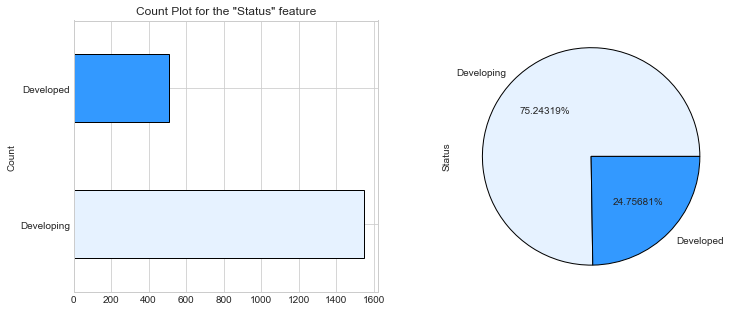

In [7]:
# Bar + Pie
ea.basic_categorical_variable_analysis(train, 'Status')

#### **Univariate & Bivariate Analysis - Numeric and Categorical**
    
* Distributions and the skewness of these distributions:
* Quartiles & Boxplots:
* Interpreting results to ascertain potential univariate outliers

#### <u>Distributions & their Skewness</u>

<ins>Skewness</ins>

* Skewness occurs when the data are distributed asymetrically (longer tail on one side)
* A left skewed (negative skewed) distribution has a longer tail on the left
* A right skewed (positive skewed) distribution has a longer tail on the right
* Will be using the 'Fisher-Pearson coefficient of skewness' to measure how asymetric the distribution of a variable is

In situations where the data has a skewed distribution, it is possible to detect univariate outliers using quartiles and the Inter-Quartile Range (IQR). We unfortunately can't use the [empirical rule](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/empirical-rule-2/) since none of our variables seem to follow a normal distribution. From the summary table earlier in the notebook:

Potential low univariate outliers $\leq$ Q1 - 1.5(IQR)

Potential high univariate outliers $\geq$ Q3 + 1.5(IQR)

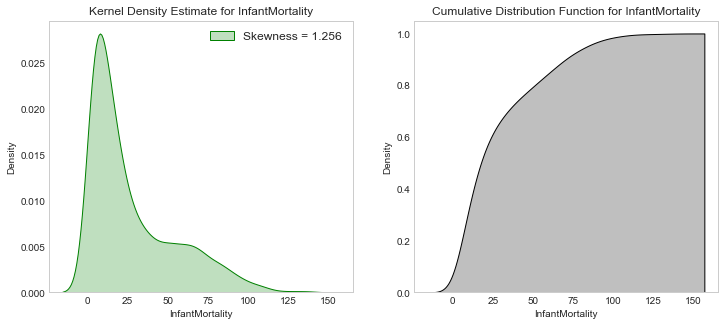

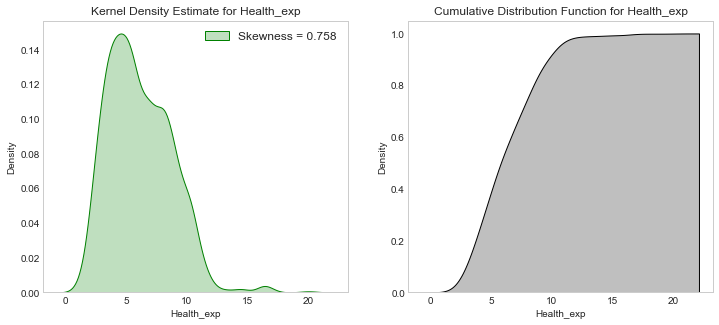

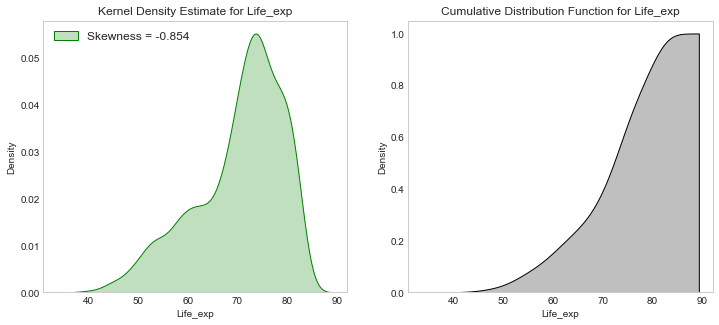

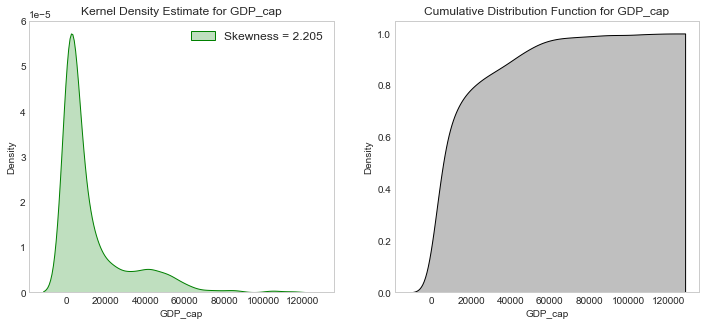

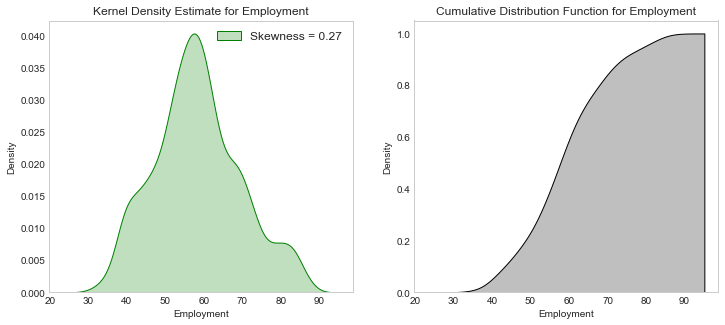

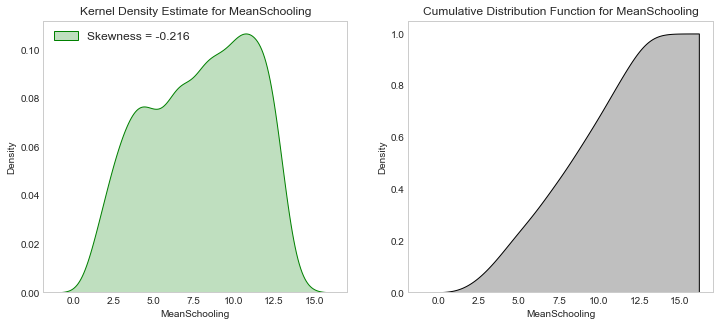

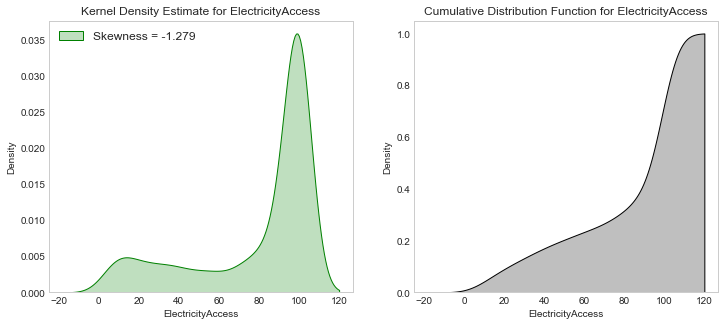

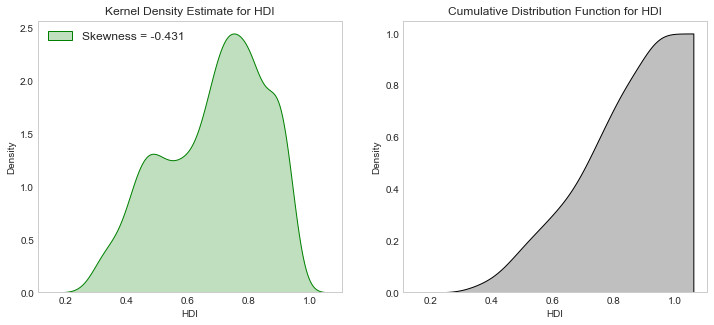

In [8]:
ea.show_skewness(data=train)

<u>Boxplots</u>

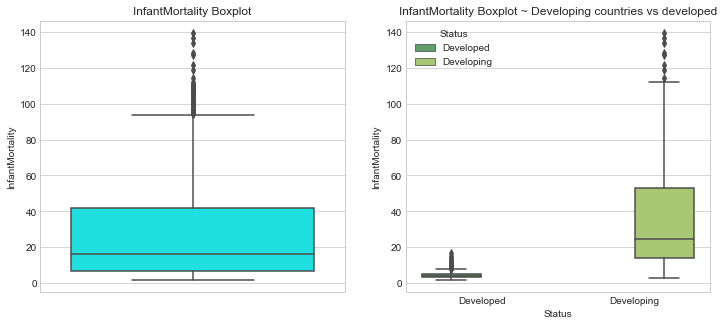

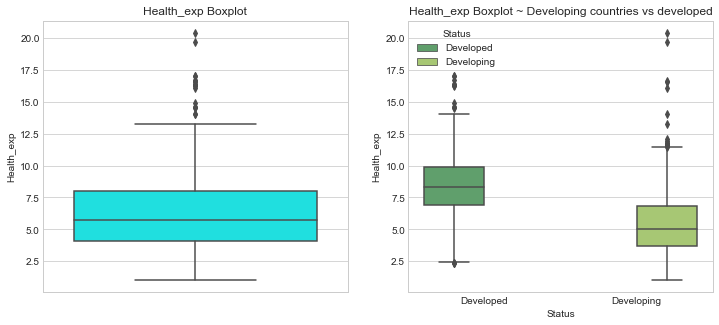

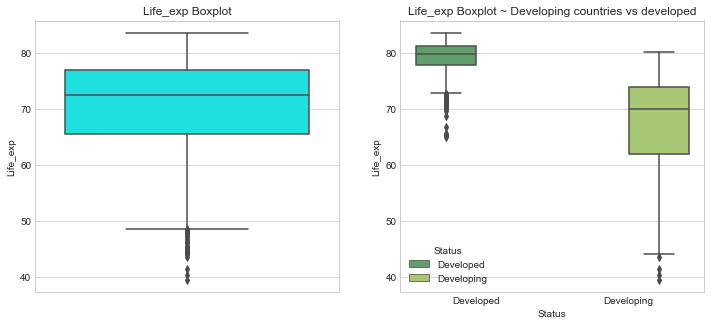

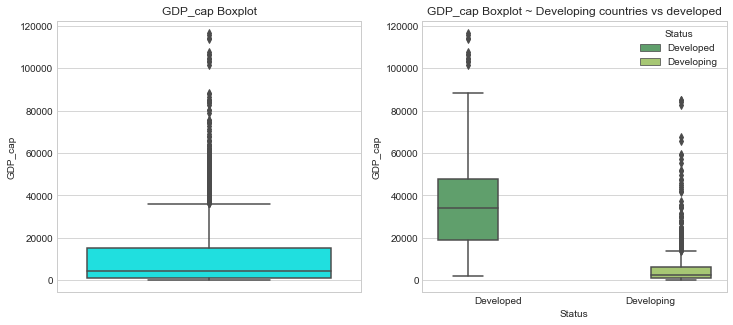

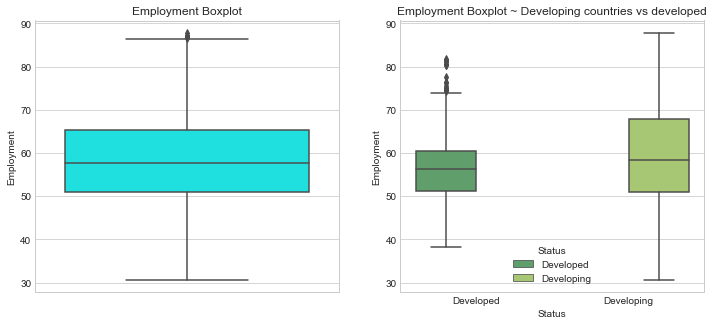

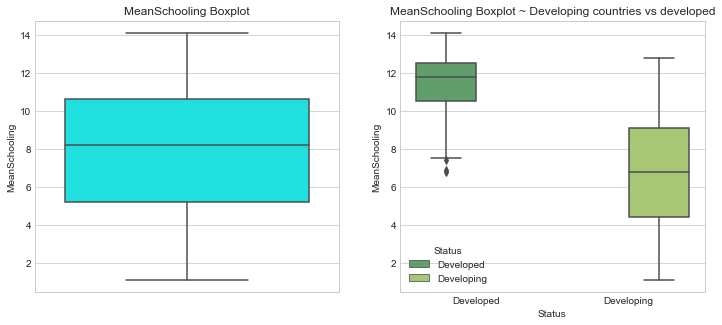

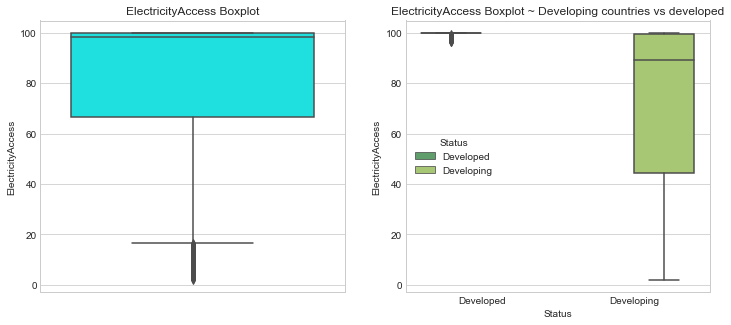

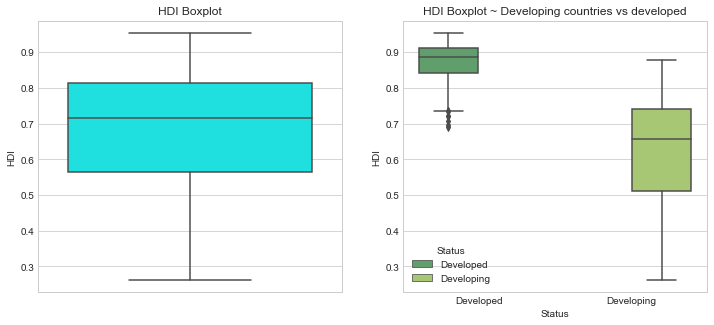

In [9]:
ea.display_boxplots(train)

**Coming up**

Next notebook will contain bivariate and multivariate analysis to get a more detailed insight about the prescence of potential outliers



